In [ ]:
# Trying different feature sets on the ensemble model

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import xgboost
import shap
import matplotlib
import itertools
import os

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("SciPy version:", scipy.__version__)
print("XGBoost version:", xgboost.__version__)
print("SHAP version:", shap.__version__)
print("Matplotlib version:", matplotlib.__version__)



NumPy version: 1.26.4
Pandas version: 1.3.3
Scikit-learn version: 1.3.0
SciPy version: 1.10.0
XGBoost version: 1.6.2
SHAP version: 0.43.0
Matplotlib version: 3.7.2


AttributeError: module 'os' has no attribute '__version__'

In [2]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

In [3]:
import pandas as pd

# Load the data
data = pd.read_csv("work_model_data.csv")

# Define features (X) and target (y)
X = data.drop(columns=["participant_id", "general_psychopathology"])  # All predictors
y = data["general_psychopathology"]

print("Data loaded successfully.")
print(f"Dataset shape: {data.shape}")
print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

Data loaded successfully.
Dataset shape: (172, 50)
Feature matrix shape: (172, 48), Target vector shape: (172,)


In [ ]:
# Nested Cross-Validation based on best individual model performances

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import shap
import numpy as np
import pandas as pd

# Define the MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define hyperparameter grids
param_grid_xgb = {'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0,2], 'n_estimators': [50, 100]}
param_grid_rf = {'max_depth': [5, 8, 10], 'n_estimators': [50, 100], 'min_samples_split': [2, 5]}

# Create bins for stratification
bins = pd.qcut(y, q=10, duplicates="drop").astype("category").cat.codes  # Convert to discrete class labels

# Outer loop: Perform stratified splitting based on bins
nested_scores = []
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in outer_cv.split(X, bins):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Create bins for the inner loop
    inner_bins = pd.qcut(y_train, q=10, duplicates="drop").cat.codes
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Grid search for XGBoost
    xgb_model = XGBRegressor(random_state=42)
    xgb_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid_xgb,
        scoring=mae_scorer,
        cv=inner_cv.split(X_train, inner_bins),
        n_jobs=-1,
        verbose=1
    )
    xgb_search.fit(X_train, y_train)

    # Grid search for Random Forest
    rf_model = RandomForestRegressor(random_state=42)
    rf_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid_rf,
        scoring=mae_scorer,
        cv=inner_cv.split(X_train, inner_bins),
        n_jobs=-1,
        verbose=1
    )
    rf_search.fit(X_train, y_train)

    # Define and fit the stacking regressor
    meta_model = LinearRegression()
    stacking_model = StackingRegressor(
        estimators=[('xgb', xgb_search.best_estimator_), ('rf', rf_search.best_estimator_)],
        final_estimator=meta_model,
        passthrough=False  # Meta-model uses only model predictions
    )
    stacking_model.fit(X_train, y_train)

    # Test predictions and metrics
    y_pred = stacking_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    nested_scores.append(test_mae)

    # Output the fold results
    print(f"Outer Fold Test MAE: {test_mae:.3f}")
    print(f"Best Params in Inner Loop for XGB: {xgb_search.best_params_}")
    print(f"Best Params in Inner Loop for RF: {rf_search.best_params_}")

# Calculate the mean and standard deviation of the nested CV scores
mean_nested_score = np.mean(nested_scores)
std_nested_score = np.std(nested_scores)

print(f"\nNested Cross-Validation Mean MAE: {mean_nested_score:.3f}")
print(f"Nested Cross-Validation Std MAE: {std_nested_score:.3f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Outer Fold Test MAE: 11.976
Best Params in Inner Loop for XGB: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Params in Inner Loop for RF: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Outer Fold Test MAE: 12.700
Best Params in Inner Loop for XGB: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Params in Inner Loop for RF: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Outer Fold Test MAE: 13.393
Best Params in Inner Loop for XGB: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Best Params in Inner Loop for RF: {'max_depth': 5, 'min_samples_split':

In [5]:
# Performing nested CV where best meta-model performance is tested based on different RF and XGBoost hyperparameters

from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

# Define hyperparameter grids for individual models
param_grid_xgb = {'max_depth': [3, 5], 'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100]}
param_grid_rf = {'max_depth': [5, 8], 'n_estimators': [50, 100]}

# Generate all combinations of hyperparameters for XGB and RF
xgb_hyperparams = list(product(*param_grid_xgb.values()))
rf_hyperparams = list(product(*param_grid_rf.values()))

# Map hyperparameter combinations to their keys
xgb_keys = list(param_grid_xgb.keys())
rf_keys = list(param_grid_rf.keys())

# Create bins for stratification
bins = pd.qcut(y, q=10, duplicates="drop").astype("category").cat.codes

# Outer CV for nested evaluation
nested_scores = []
best_combinations = []
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store individual model test MAEs
individual_model_maes = {"xgb": [], "rf": []}

for train_idx, test_idx in outer_cv.split(X, bins):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Create inner CV bins for training
    inner_bins = pd.qcut(y_train, q=10, duplicates="drop").astype("category").cat.codes
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate all hyperparameter combinations for individual models
    fold_results = []

    for xgb_params in xgb_hyperparams:
        for rf_params in rf_hyperparams:
            # Initialize models with current hyperparameter combination
            xgb_model = XGBRegressor(**dict(zip(xgb_keys, xgb_params)), random_state=42)
            rf_model = RandomForestRegressor(**dict(zip(rf_keys, rf_params)), random_state=42)

            # Meta-Model: Ridge Regression
            stacking_model = StackingRegressor(
                estimators=[('xgb', xgb_model), ('rf', rf_model)],
                final_estimator=Ridge(),
                passthrough=False  # Meta-model uses predictions only
            )

            # Inner loop for cross-validation on training set
            inner_maes = []
            for inner_train_idx, inner_val_idx in inner_cv.split(X_train, inner_bins):
                X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
                y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

                # Fit stacking model
                stacking_model.fit(X_inner_train, y_inner_train)

                # Validate on the inner validation set
                y_inner_pred = stacking_model.predict(X_inner_val)
                mae = mean_absolute_error(y_inner_val, y_inner_pred)
                inner_maes.append(mae)

            # Average MAE across inner folds
            avg_inner_mae = np.mean(inner_maes)

            # Record results for this combination
            fold_results.append({
                "xgb_params": dict(zip(xgb_keys, xgb_params)),
                "rf_params": dict(zip(rf_keys, rf_params)),
                "inner_mae": avg_inner_mae
            })

    # Select the best combination of hyperparameters for the current fold
    best_combination = min(fold_results, key=lambda x: x["inner_mae"])
    best_combinations.append(best_combination)

    # Test the best stacking model on the outer test set
    xgb_best = XGBRegressor(**best_combination["xgb_params"], random_state=42)
    rf_best = RandomForestRegressor(**best_combination["rf_params"], random_state=42)

    # Train and test individual models
    xgb_best.fit(X_train, y_train)
    rf_best.fit(X_train, y_train)

    xgb_test_pred = xgb_best.predict(X_test)
    rf_test_pred = rf_best.predict(X_test)

    xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
    rf_test_mae = mean_absolute_error(y_test, rf_test_pred)

    individual_model_maes["xgb"].append(xgb_test_mae)
    individual_model_maes["rf"].append(rf_test_mae)

    # Fit the stacking model
    stacking_model = StackingRegressor(
        estimators=[('xgb', xgb_best), ('rf', rf_best)],
        final_estimator=Ridge(),
        passthrough=False
    )

    # Evaluate on the test set
    stacking_model.fit(X_train, y_train)
    y_test_pred = stacking_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    nested_scores.append(test_mae)

    # Output fold results
    print(f"Outer Fold Test MAE (Meta-Model): {test_mae:.3f}")
    print(f"Best XGB Params: {best_combination['xgb_params']}")
    print(f"Best RF Params: {best_combination['rf_params']}")
    print(f"XGB Test MAE: {xgb_test_mae:.3f}")
    print(f"RF Test MAE: {rf_test_mae:.3f}")

# Calculate the mean and standard deviation of the nested CV scores
mean_nested_score = np.mean(nested_scores)
std_nested_score = np.std(nested_scores)

print(f"\nNested Cross-Validation Mean MAE (Meta-Model): {mean_nested_score:.3f}")
print(f"Nested Cross-Validation Std MAE (Meta-Model): {std_nested_score:.3f}")

# Calculate mean MAE for individual models
xgb_mean_mae = np.mean(individual_model_maes["xgb"])
rf_mean_mae = np.mean(individual_model_maes["rf"])

print(f"\nMean MAE (XGB): {xgb_mean_mae:.3f}")
print(f"Mean MAE (RF): {rf_mean_mae:.3f}")


Outer Fold Test MAE (Meta-Model): 11.964
Best XGB Params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}
Best RF Params: {'max_depth': 8, 'n_estimators': 50}
XGB Test MAE: 13.957
RF Test MAE: 13.974
Outer Fold Test MAE (Meta-Model): 12.719
Best XGB Params: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 50}
Best RF Params: {'max_depth': 5, 'n_estimators': 100}
XGB Test MAE: 11.300
RF Test MAE: 12.914
Outer Fold Test MAE (Meta-Model): 13.618
Best XGB Params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}
Best RF Params: {'max_depth': 8, 'n_estimators': 100}
XGB Test MAE: 13.487
RF Test MAE: 12.623
Outer Fold Test MAE (Meta-Model): 11.968
Best XGB Params: {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 50}
Best RF Params: {'max_depth': 5, 'n_estimators': 100}
XGB Test MAE: 60.154
RF Test MAE: 12.521
Outer Fold Test MAE (Meta-Model): 12.214
Best XGB Params: {'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 100}
Best RF Params: {'max_depth': 8

In [40]:
# Model training and evaluation

from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd

# Separate features (X) and target (y)
X = data.drop(columns=["participant_id", "general_psychopathology"])
y = data["general_psychopathology"]

# Stratify the train/test split
stratify_bins = pd.qcut(y, q=10, duplicates="drop").astype("category").cat.codes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=stratify_bins, random_state=42
)

# Train baseline models with optimal hyperparameters
xgb_optimized = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=50, random_state=42)
rf_optimized = RandomForestRegressor(max_depth=None, min_samples_split=2, n_estimators=100, random_state=42)

# Train the stacking ensemble model
meta_model = GradientBoostingRegressor(n_estimators=50, random_state=42)
stacking_model = StackingRegressor(
    estimators=[('xgb', xgb_optimized), ('rf', rf_optimized)],
    final_estimator=meta_model,
    passthrough=False  # Remove passthrough to exclude the original features from the meta-model
)

# Fit the models
xgb_optimized.fit(X_train, y_train)
rf_optimized.fit(X_train, y_train)
stacking_model.fit(X_train, y_train)

# Test all models on X_test
xgb_pred = xgb_optimized.predict(X_test)
rf_pred = rf_optimized.predict(X_test)
ensemble_pred = stacking_model.predict(X_test)

# Calculate MAE for each model
xgb_mae = mean_absolute_error(y_test, xgb_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)

# Print results
print(f"XGBoost Test MAE: {xgb_mae:.3f}")
print(f"Random Forest Test MAE: {rf_mae:.3f}")
print(f"Ensemble (Stacking) Test MAE: {ensemble_mae:.3f}")

XGBoost Test MAE: 14.116
Random Forest Test MAE: 13.075
Ensemble (Stacking) Test MAE: 12.684


In [35]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np
import pandas as pd

# Define the MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define hyperparameter grid for the GradientBoostingRegressor meta-model
meta_param_grid = {
    'final_estimator__n_estimators': [50, 100, 150],
    'final_estimator__learning_rate': [0.01, 0.05, 0.1],
    'final_estimator__max_depth': [3, 5, 7]
}

# Outer loop: Perform K-fold cross-validation for regression
nested_scores = []
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in outer_cv.split(X, y):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Define the stacking regressor with pre-optimized individual models
    base_estimators = [
        ('xgb', xgb_optimized),  # Pre-trained XGB with optimal hyperparameters
        ('rf', rf_optimized)     # Pre-trained RF with optimal hyperparameters
    ]
    stacking_model = StackingRegressor(
        estimators=base_estimators,
        final_estimator=GradientBoostingRegressor(random_state=42),  # Meta-model to be tuned
        passthrough=False
    )

    # Grid search for the ensemble's meta-model
    stacking_search = GridSearchCV(
        estimator=stacking_model,
        param_grid=meta_param_grid,
        scoring=mae_scorer,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),  # Inner cross-validation for regression
        n_jobs=-1,
        verbose=1
    )
    stacking_search.fit(X_train, y_train)

    # Test the best stacking model on the outer test set
    best_stacking_model = stacking_search.best_estimator_
    y_pred = best_stacking_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    nested_scores.append(test_mae)

    # Output the fold results
    print(f"Outer Fold Test MAE: {test_mae:.3f}")
    print(f"Best Params for Meta-Model: {stacking_search.best_params_}")

# Calculate the mean and standard deviation of the nested CV scores
mean_nested_score = np.mean(nested_scores)
std_nested_score = np.std(nested_scores)

print(f"\nNested Cross-Validation Mean MAE: {mean_nested_score:.3f}")
print(f"Nested Cross-Validation Std MAE: {std_nested_score:.3f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Outer Fold Test MAE: 11.963
Best Params for Meta-Model: {'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 3, 'final_estimator__n_estimators': 50}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Outer Fold Test MAE: 12.977
Best Params for Meta-Model: {'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 3, 'final_estimator__n_estimators': 50}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Outer Fold Test MAE: 10.094
Best Params for Meta-Model: {'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 50}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Outer Fold Test MAE: 13.898
Best Params for Meta-Model: {'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 50}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Outer Fold Test MAE: 1

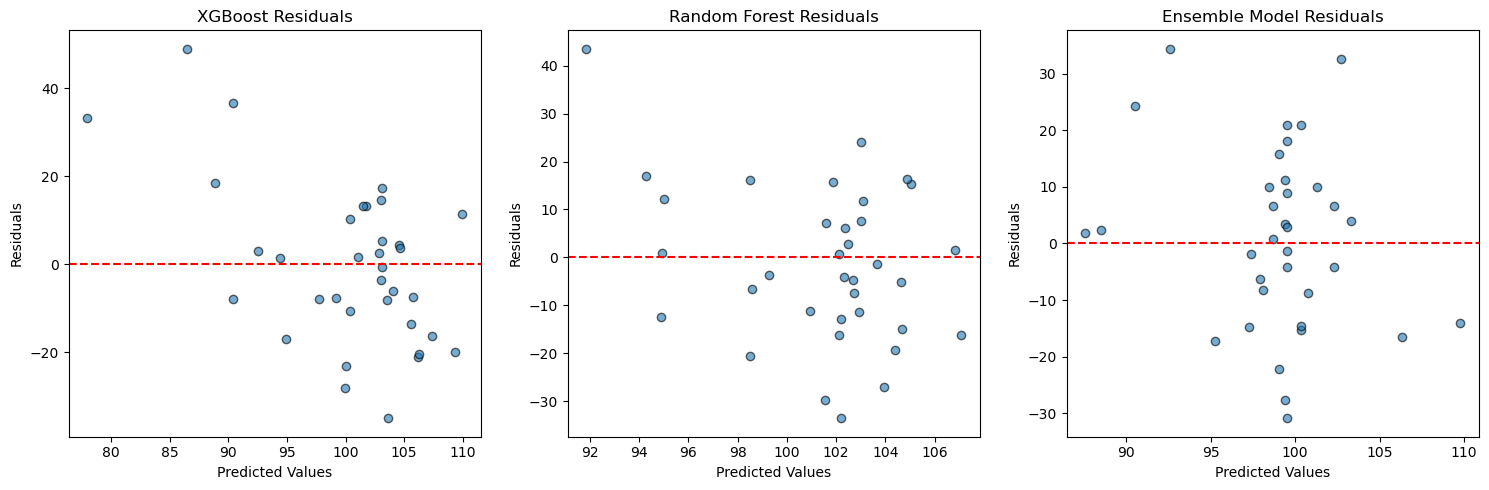

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals for each model
xgb_residuals = y_test - xgb_pred
rf_residuals = y_test - rf_pred
ensemble_residuals = y_test - ensemble_pred

# Create a figure for residuals plots
plt.figure(figsize=(15, 5))

# Residuals for XGBoost
plt.subplot(1, 3, 1)
plt.scatter(xgb_pred, xgb_residuals, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("XGBoost Residuals")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Residuals for Random Forest
plt.subplot(1, 3, 2)
plt.scatter(rf_pred, rf_residuals, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Random Forest Residuals")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Residuals for Ensemble Model
plt.subplot(1, 3, 3)
plt.scatter(ensemble_pred, ensemble_residuals, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Ensemble Model Residuals")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


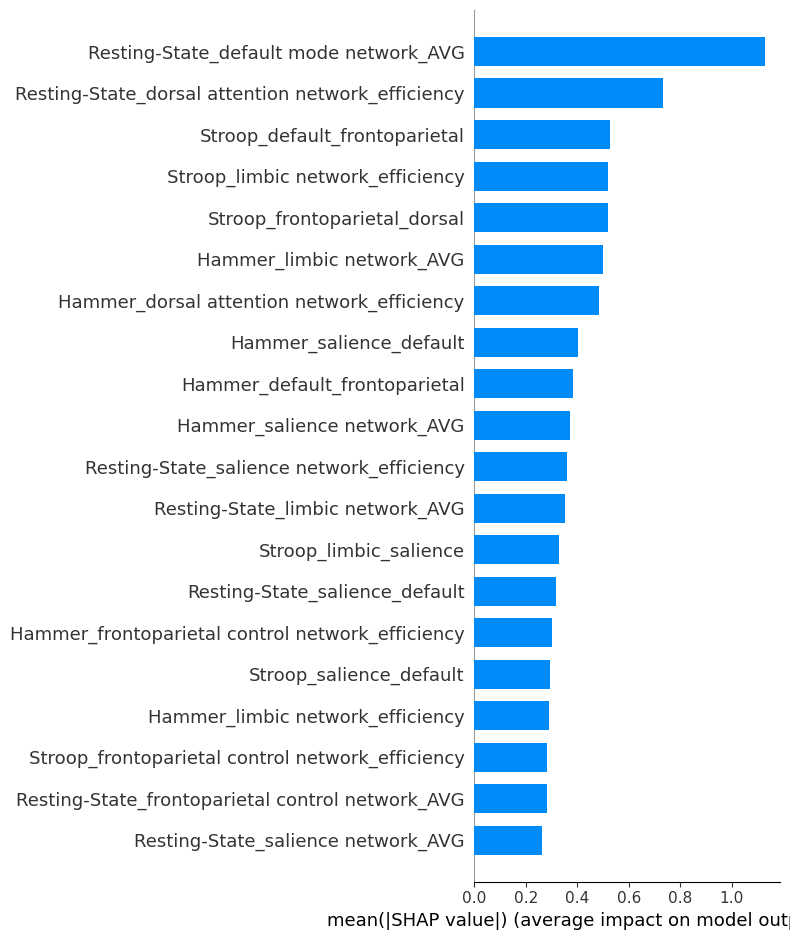

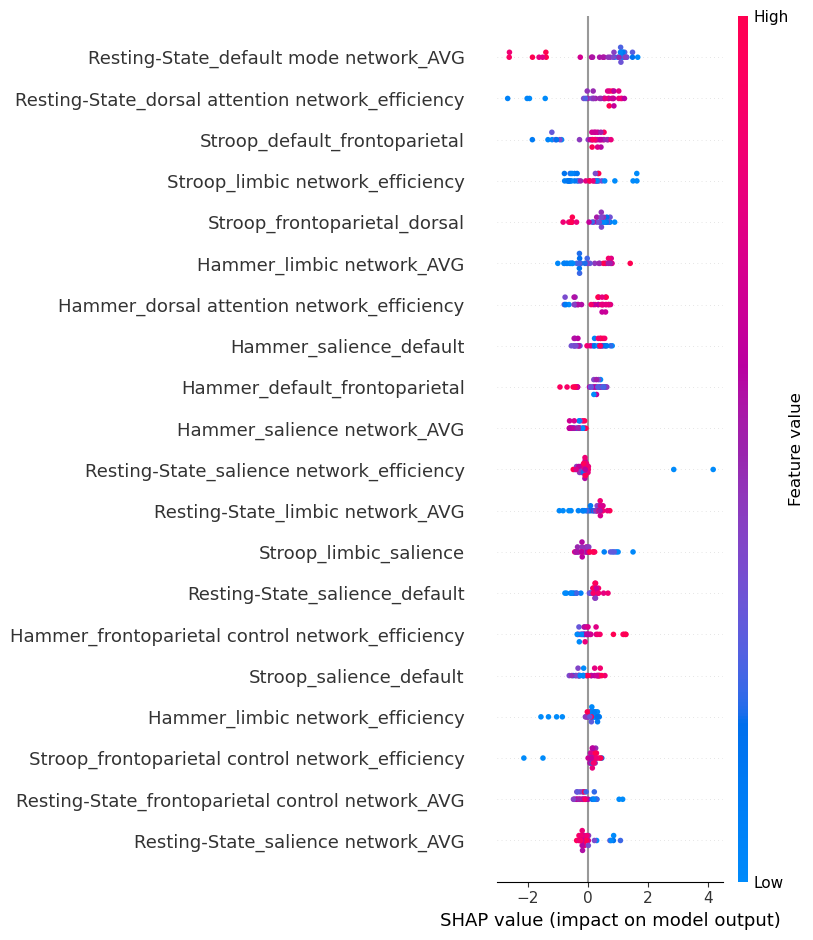

In [26]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer for the trained Random Forest model
explainer = shap.TreeExplainer(rf_optimized)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot for feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary plot showing distributions of SHAP values
shap.summary_plot(shap_values, X_test)


In [ ]:
# Normalize and save SHAP values into new file

import pandas as pd
import shap

# Initialize the SHAP explainers for the optimized models
rf_explainer_optimized = shap.TreeExplainer(rf_optimized)
xgb_explainer_optimized = shap.TreeExplainer(xgb_optimized)

# Calculate SHAP values for the test set
rf_shap_values_optimized = rf_explainer_optimized.shap_values(X_test)
xgb_shap_values_optimized = xgb_explainer_optimized.shap_values(X_test)

# Compute mean absolute SHAP values for each feature
rf_mean_shap_optimized = pd.DataFrame({
    'Feature': X_test.columns,
    'Random Forest SHAP': abs(rf_shap_values_optimized).mean(axis=0)
})

xgb_mean_shap_optimized = pd.DataFrame({
    'Feature': X_test.columns,
    'XGBoost SHAP': abs(xgb_shap_values_optimized).mean(axis=0)
})

# Normalize the SHAP values by dividing each column by its maximum value
rf_mean_shap_optimized['Random Forest SHAP'] /= rf_mean_shap_optimized['Random Forest SHAP'].max()
xgb_mean_shap_optimized['XGBoost SHAP'] /= xgb_mean_shap_optimized['XGBoost SHAP'].max()

# Merge the normalized SHAP values from both models
optimized_shap_combined = pd.merge(
    xgb_mean_shap_optimized,
    rf_mean_shap_optimized,
    on='Feature'
)

# Display the combined normalized SHAP values
print("Normalized SHAP Values for Optimized Models:")
print(optimized_shap_combined.head())

# Save the normalized SHAP values to a single file
optimized_shap_combined.to_csv('optimized_results/optimized_feature_shap.csv', index=False)
print("Saved normalized SHAP values for both optimized models.")


Normalized SHAP Values for Optimized Models:
                                            Feature  XGBoost SHAP  \
0            Resting-State_default mode network_AVG      1.000000   
1        Resting-State_dorsal attention network_AVG      0.125704   
2  Resting-State_frontoparietal control network_AVG      0.412014   
3                  Resting-State_limbic network_AVG      0.247318   
4                Resting-State_salience network_AVG      0.285922   

   Random Forest SHAP  
0            1.000000  
1            0.159893  
2            0.364725  
3            0.332213  
4            0.252446  
Saved normalized SHAP values for both optimized models.


In [ ]:
# Check performance of model with only top 20 most important features included

# Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to pair features with their mean SHAP values
shap_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Mean_SHAP_Value": mean_shap_values
}).sort_values(by="Mean_SHAP_Value", ascending=False)

# Get the top 20 features based on SHAP importance
top_20_features = shap_importance.head(20)["Feature"].tolist()

# Subset the datasets to include only the top 20 features
X_train_top20 = X_train[top_20_features]
X_test_top20 = X_test[top_20_features]

# Re-train and evaluate the models using the reduced feature set
xgb_optimized.fit(X_train_top20, y_train)
rf_optimized.fit(X_train_top20, y_train)
stacking_model.fit(X_train_top20, y_train)

# Test all models on the reduced test set
xgb_pred_top20 = xgb_optimized.predict(X_test_top20)
rf_pred_top20 = rf_optimized.predict(X_test_top20)
ensemble_pred_top20 = stacking_model.predict(X_test_top20)

# Calculate MAE for each model with the top 20 features
xgb_mae_top20 = mean_absolute_error(y_test, xgb_pred_top20)
rf_mae_top20 = mean_absolute_error(y_test, rf_pred_top20)
ensemble_mae_top20 = mean_absolute_error(y_test, ensemble_pred_top20)

# Print the results
print("Model Performance with Top 20 Features:")
print(f"XGBoost Test MAE: {xgb_mae_top20:.3f}")
print(f"Random Forest Test MAE: {rf_mae_top20:.3f}")
print(f"Ensemble (Stacking) Test MAE: {ensemble_mae_top20:.3f}")

Model Performance with Top 20 Features:
XGBoost Test MAE: 14.297
Random Forest Test MAE: 13.113
Ensemble (Stacking) Test MAE: 13.172


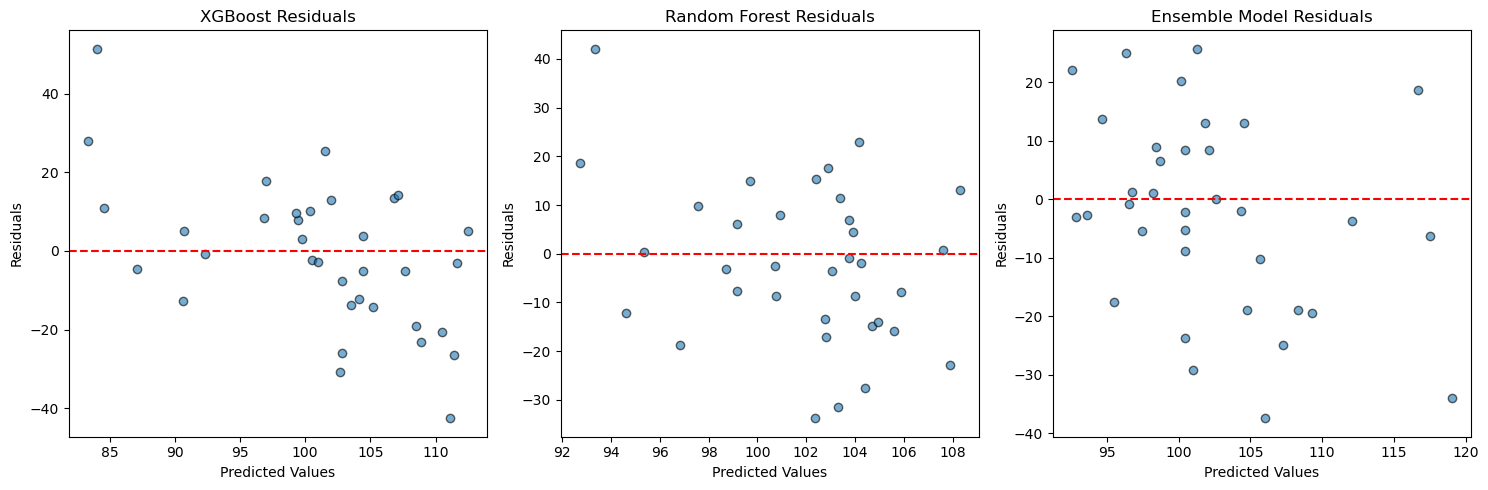

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals for each model
xgb_residuals_top20 = y_test - xgb_pred_top20
rf_residuals_top20 = y_test - rf_pred_top20
ensemble_residuals_top20 = y_test - ensemble_pred_top20

# Create a figure for residuals plots
plt.figure(figsize=(15, 5))

# Residuals for XGBoost
plt.subplot(1, 3, 1)
plt.scatter(xgb_pred_top20, xgb_residuals_top20, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("XGBoost Residuals")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Residuals for Random Forest
plt.subplot(1, 3, 2)
plt.scatter(rf_pred_top20, rf_residuals_top20, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Random Forest Residuals")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Residuals for Ensemble Model
plt.subplot(1, 3, 3)
plt.scatter(ensemble_pred_top20, ensemble_residuals_top20, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Ensemble Model Residuals")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


In [ ]:
# Now store the results

In [36]:
import os

# Create the folder 'optimized_results' if it doesn't exist
os.makedirs('optimized_results', exist_ok=True)

print("Created folder 'optimized_results' to store the optimized model results.")


Created folder 'optimized_results' to store the optimized model results.


In [41]:
# Save optimized model MAE into new file
import pandas as pd

# Prepare the results dictionary for optimized MAE
optimized_mae_results = {
    'Model': ['XGBoost', 'Random Forest', 'Ensemble'],
    'Optimized MAE': [xgb_mae, rf_mae, ensemble_mae]
}

# Create and save the MAE DataFrame
optimized_mae_results_df = pd.DataFrame(optimized_mae_results)
optimized_mae_results_df.to_csv('optimized_results/optimized_mae.csv', index=False)

print("Saved optimized MAE results to 'optimized_results/optimized_mae.csv'.")


Saved optimized MAE results to 'optimized_results/optimized_mae.csv'.


In [ ]:
# feature SHAP values were stored in an earlier code block: 'Normalize and save SHAP values into new file'

In [45]:
# Compute and save normalized SHAP values for both models
# Initialize the SHAP explainer for the meta-model (GradientBoostingRegressor)
meta_explainer = shap.TreeExplainer(stacking_model.final_estimator_)

# Calculate SHAP values for the predictions of base models (XGBoost, Random Forest)
meta_shap_values = meta_explainer.shap_values(stacking_model.transform(X_test))

# Compute mean absolute SHAP values for each base model (XGBoost and Random Forest)
meta_model_shap_df = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest'],
    'Normalized SHAP': abs(meta_shap_values).mean(axis=0)
})

# Normalize the SHAP values by dividing by the maximum value
meta_model_shap_df['Normalized SHAP'] /= meta_model_shap_df['Normalized SHAP'].max()

# Save the normalized model SHAP values to a CSV file
meta_model_shap_df.to_csv('optimized_results/optimized_model_shap.csv', index=False)

print("Saved normalized model SHAP values to 'optimized_results/optimized_model_shap.csv'.")

print(meta_model_shap_df)

Saved normalized model SHAP values to 'optimized_results/optimized_model_shap.csv'.
           Model  Normalized SHAP
0        XGBoost         1.000000
1  Random Forest         0.921365


In [1]:
# Trying normalization for all input features and see what it does to model performance
import pandas as pd

# Load the file to inspect its structure
file_path = 'work_model_data.csv'
df = pd.read_csv(file_path)

# Display the first few rows to inspect the structure and column names
df.head(), df.info()

# Import necessary library
from sklearn.preprocessing import MinMaxScaler

# Columns to exclude from normalization
exclude_columns = ['participant_id', 'general_psychopathology']

# Identify columns to normalize
columns_to_normalize = [col for col in df.columns if col not in exclude_columns]

# Initialize the scaler
scaler = MinMaxScaler()

# Apply normalization to the relevant columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Save the updated DataFrame to a new file
normalized_file_path = 'work_model_data_normalized.csv'
df.to_csv(normalized_file_path, index=False)

# Confirm the file has been saved
normalized_file_path


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 50 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   participant_id                                           172 non-null    object 
 1   general_psychopathology                                  172 non-null    float64
 2   Resting-State_default mode network_AVG                   172 non-null    float64
 3   Resting-State_dorsal attention network_AVG               172 non-null    float64
 4   Resting-State_frontoparietal control network_AVG         172 non-null    float64
 5   Resting-State_limbic network_AVG                         172 non-null    float64
 6   Resting-State_salience network_AVG                       172 non-null    float64
 7   Hammer_default mode network_AVG                          172 non-null    float64
 8   Hammer_dorsal attention networ

'work_model_data_normalized.csv'

In [2]:
# Load data
data = pd.read_csv('work_model_data_normalized.csv')
print(data.head())

     participant_id  general_psychopathology  \
0  NDAR_INVDW733XXB                96.923340   
1  NDAR_INVEV975LY3               119.803520   
2  NDAR_INVKV870NBK               113.809580   
3  NDAR_INVXJ707NAE                76.470000   
4  NDAR_INVWD467AR0                85.819786   

   Resting-State_default mode network_AVG  \
0                                0.495602   
1                                0.466176   
2                                0.181734   
3                                0.763710   
4                                0.499903   

   Resting-State_dorsal attention network_AVG  \
0                                    0.660379   
1                                    0.396265   
2                                    0.506586   
3                                    0.450455   
4                                    0.568185   

   Resting-State_frontoparietal control network_AVG  \
0                                          0.363082   
1                                  

In [3]:
# Model training and evaluation

from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd

# Separate features (X) and target (y)
X = data.drop(columns=["participant_id", "general_psychopathology"])
y = data["general_psychopathology"]

# Stratify the train/test split
stratify_bins = pd.qcut(y, q=10, duplicates="drop").astype("category").cat.codes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=stratify_bins, random_state=42
)

# Train baseline models with optimal hyperparameters
xgb_optimized = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=50, random_state=42)
rf_optimized = RandomForestRegressor(max_depth=None, min_samples_split=2, n_estimators=100, random_state=42)

# Train the stacking ensemble model
meta_model = GradientBoostingRegressor(n_estimators=50, random_state=42)
stacking_model = StackingRegressor(
    estimators=[('xgb', xgb_optimized), ('rf', rf_optimized)],
    final_estimator=meta_model,
    passthrough=False  # Remove passthrough to exclude the original features from the meta-model
)

# Fit the models
xgb_optimized.fit(X_train, y_train)
rf_optimized.fit(X_train, y_train)
stacking_model.fit(X_train, y_train)

# Test all models on X_test
xgb_pred = xgb_optimized.predict(X_test)
rf_pred = rf_optimized.predict(X_test)
ensemble_pred = stacking_model.predict(X_test)

# Calculate MAE for each model
xgb_mae = mean_absolute_error(y_test, xgb_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)

# Print results
print(f"XGBoost Test MAE: {xgb_mae:.3f}")
print(f"Random Forest Test MAE: {rf_mae:.3f}")
print(f"Ensemble (Stacking) Test MAE: {ensemble_mae:.3f}")

XGBoost Test MAE: 14.116
Random Forest Test MAE: 13.075
Ensemble (Stacking) Test MAE: 12.357
